In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.9 MB/s eta 0:00:00


In [2]:
!pip install datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.0 MB/s eta 0:00:00


In [3]:
# Data processing
import pandas as pd
import numpy as np
import nltk

# Modeling
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

In [4]:
# Read in data
eating_disorders = pd.read_csv('data.csv', sep=',')

eating_disorders.head()

,text,label
0,"Hola encantada soy Ana , algún gimnasio que me...",0
1,Señores la eterna pregunta O cuál es la más ba...,0
2,Holaa me llamo maria y soy ana ( pronto tambie...,1
3,Cuando cenas al fresco las ves cazando misquit...,0
4,Este grupo es para presentar dudas de lo que s...,1


In [ ]:
# Get the dataset information
eating_disorders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    175 non-null    object
 1   label   175 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


In [ ]:
eating_disorders['label'].value_counts()

0    101
1     74
Name: label, dtype: int64

In [5]:
# Training dataset
train_data = eating_disorders.sample(frac=0.8, random_state=42)

# Testing dataset
test_data = eating_disorders.drop(train_data.index)

# Check the number of records in training and testing dataset.
print(f'The training dataset has {len(train_data)} records.')
print(f'The testing dataset has {len(test_data)} records.')

The training dataset has 140 records.
The testing dataset has 35 records.


In [ ]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

In [ ]:
# Length of the Dataset
print(f'The length of hg_train_data is {len(hg_train_data)}.\n')

# Check one review
hg_train_data[0]

The length of hg_train_data is 140.



{'text': 'Verónica , Mía sinceramente ns mi peso actual pq mis padres tiraron la pesa , me gustaría pesar 44 , 16 años Te metes los dedos A mi me costó unas semanas Ah de forma clásica yo vómito pq si dejo de comer se Dan cuenta Es q quería poner * Mía ayuda a personas q nos vigilan comer No tengo otra solución Supongo q no es tan efectivo Pero al menos me ayuda a sentirme menos mierda Tío , eres la mejor admin d grupo d los q he visto hasta ahora corazón rojo corazón rojo T implicas mucho por apoyarnos :) ) ',
 'label': 1,
 '__index_level_0__': 156}

In [ ]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/bsc-bio-ehr-es")

# Take a look at the tokenizer
tokenizer

RobertaTokenizerFast(name_or_path='PlanTL-GOB-ES/bsc-bio-ehr-es', vocab_size=50262, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["text"], 
                     max_length=512, 
                     truncation=True, 
                     padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

In [ ]:
# Take a look at the data
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 140
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 35
})


In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("PlanTL-GOB-ES/bsc-bio-ehr-es", num_labels=2)


Some weights of the model checkpoint at PlanTL-GOB-ES/bsc-bio-ehr-es were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/bsc-bio-ehr-es and are newly initialized: ['classifier.dense.weight', 'classifier.ou

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./eating_disorder/",          
    logging_dir='./eating_disorder/logs/',            
    logging_strategy='epoch',
    logging_steps=25,    
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    learning_rate=2e-5,
    seed=42,
    save_strategy='epoch',
    save_steps=25,
    evaluation_strategy='epoch',
    eval_steps=25,
    load_best_model_at_end=True
)

In [ ]:
# Number of evaluation modules
print(f'There are {len(evaluate.list_evaluation_modules())} evaluation models in Hugging Face.\n')

# List all evaluation metrics
evaluate.list_evaluation_modules()

There are 143 evaluation models in Hugging Face.



['lvwerra/test',
 'precision',
 'code_eval',
 'roc_auc',
 'cuad',
 'xnli',
 'rouge',
 'pearsonr',
 'mse',
 'super_glue',
 'comet',
 'cer',
 'sacrebleu',
 'mahalanobis',
 'wer',
 'competition_math',
 'f1',
 'recall',
 'coval',
 'mauve',
 'xtreme_s',
 'bleurt',
 'ter',
 'accuracy',
 'exact_match',
 'indic_glue',
 'spearmanr',
 'mae',
 'squad',
 'chrf',
 'glue',
 'perplexity',
 'mean_iou',
 'squad_v2',
 'meteor',
 'bleu',
 'wiki_split',
 'sari',
 'frugalscore',
 'google_bleu',
 'bertscore',
 'matthews_correlation',
 'seqeval',
 'trec_eval',
 'rl_reliability',
 'jordyvl/ece',
 'angelina-wang/directional_bias_amplification',
 'cpllab/syntaxgym',
 'lvwerra/bary_score',
 'kaggle/amex',
 'kaggle/ai4code',
 'hack/test_metric',
 'yzha/ctc_eval',
 'codeparrot/apps_metric',
 'mfumanelli/geometric_mean',
 'daiyizheng/valid',
 'poseval',
 'erntkn/dice_coefficient',
 'mgfrantz/roc_auc_macro',
 'Vlasta/pr_auc',
 'gorkaartola/metric_for_tp_fp_samples',
 'idsedykh/metric',
 'idsedykh/codebleu2',
 'idsed

In [ ]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.667800,0.647997,0.600000
2,0.591400,0.598841,0.771429
3,0.506200,0.534169,0.800000
4,0.408400,0.510202,0.771429
5,0.326800,0.488177,0.800000


TrainOutput(global_step=45, training_loss=0.5001203060150147, metrics={'train_runtime': 100.8045, 'train_samples_per_second': 6.944, 'train_steps_per_second': 0.446, 'total_flos': 184177738752000.0, 'train_loss': 0.5001203060150147, 'epoch': 5.0})

In [ ]:
# Predictions
y_test_predict = trainer.predict(dataset_test)

# Take a look at the predictions
y_test_predict

PredictionOutput(predictions=array([[ 0.8660902 , -0.84613305],
       [-0.30773407,  0.32541317],
       [ 0.7806507 , -0.55863804],
       [ 1.0597761 , -1.0700698 ],
       [ 0.4949216 , -0.36426258],
       [ 0.09513322, -0.19348584],
       [ 0.79869086, -0.75557256],
       [ 0.91178966, -0.78826696],
       [ 0.9427204 , -0.5859421 ],
       [-0.508251  ,  0.4405011 ],
       [-0.15550296,  0.3404374 ],
       [-0.00740672,  0.3420422 ],
       [-0.42033955,  0.60943246],
       [ 0.73477626, -0.55472606],
       [ 0.9780198 , -0.54832786],
       [-0.5049962 ,  0.59180105],
       [ 0.5227459 , -0.4786745 ],
       [ 1.033824  , -0.8578746 ],
       [ 0.67305845, -0.4622156 ],
       [ 0.84049374, -0.6133749 ],
       [-0.9008807 ,  0.91895056],
       [ 0.494519  , -0.16688178],
       [ 1.0560367 , -0.7370976 ],
       [-0.15855537,  0.29324138],
       [ 0.15224756, -0.1314174 ],
       [ 1.2192198 , -0.8873566 ],
       [-0.33858782,  0.38711476],
       [ 0.63179433, -0.57

In [ ]:
# Predicted logits
y_test_logits = y_test_predict.predictions

# First 5 predicted probabilities
y_test_logits[:5]

array([[ 0.8660902 , -0.84613305],
       [-0.30773407,  0.32541317],
       [ 0.7806507 , -0.55863804],
       [ 1.0597761 , -1.0700698 ],
       [ 0.4949216 , -0.36426258]], dtype=float32)

In [ ]:
# Predicted probabilities
y_test_probabilities = tf.nn.softmax(y_test_logits)

# First 5 predicted logits
y_test_probabilities[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.8471244 , 0.15287556],
       [0.34679726, 0.6532028 ],
       [0.79237294, 0.20762704],
       [0.8937704 , 0.10622963],
       [0.70249015, 0.29750985]], dtype=float32)>

In [ ]:
# Predicted labels
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)

# First 5 predicted probabilities
y_test_pred_labels[:5]

array([0, 1, 0, 0, 0])

In [ ]:
# Actual labels
y_test_actual_labels = y_test_predict.label_ids

# First 5 predicted probabilities
y_test_actual_labels[:5]

array([0, 0, 0, 0, 0])

In [ ]:
# Trainer evaluate
trainer.evaluate(dataset_test)

{'eval_loss': 0.48817721009254456,
 'eval_accuracy': 0.8,
 'eval_runtime': 1.4913,
 'eval_samples_per_second': 23.47,
 'eval_steps_per_second': 2.012,
 'epoch': 5.0}

In [ ]:
# Load precision metric
metric_precision = evaluate.load("precision")

# Compute precision metric
print(metric_precision.compute(predictions=y_test_pred_labels, references=y_test_actual_labels))

# Load recall metric
metric_recall = evaluate.load("recall")

# Compute recall metric
print(metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels))

# Load f1 metric
metric_f1 = evaluate.load("f1")

# Compute f1 metric
print(metric_f1.compute(predictions=y_test_pred_labels, references=y_test_actual_labels))

{'precision': 0.8181818181818182}


{'recall': 0.6428571428571429}


{'f1': 0.7200000000000001}


In [ ]:
# Save tokenizer
tokenizer.save_pretrained('./eating_disorder/')

# Save model
trainer.save_model('./eating_disorder/')

# Análisis exploratorio

In [6]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re
import string

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
result = set(stopwords.words('spanish'))
print("List of stopwords in spanish:")
print (len(result))
print("\nOmit - 'mía':")
stop_words = set(stopwords.words('spanish')) - set(['mía'])
print("\nList of fresh stopwords in spanish:")
print (len(stop_words))

List of stopwords in spanish:
313

Omit - 'mía':

List of fresh stopwords in spanish:
312


In [22]:
def word_count_func(text):
    '''
    Counts words within a string
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Number of words within a string, integer
    ''' 
    return len(text.split())

table = str.maketrans('', '', string.punctuation)

def text_process(mess):
    words = re.split(r'\W+', mess)
    nopunc = [w.translate(table) for w in words]
    nostop =  ' '.join([word for word in nopunc if word.lower() not in stop_words])
    return nostop

In [23]:
eating_disorders['tokenized'] = eating_disorders['text'].apply(word_tokenize)
eating_disorders['no_stopwords'] = eating_disorders['text'].apply(text_process)

In [24]:
eating_disorders

,text,label,tokenized,no_stopwords,text_lemma
0,"Hola encantada soy Ana , algún gimnasio que me...",0,"[Hola, encantada, soy, Ana, ,, algún, gimnasio...",Hola encantada Ana algún gimnasio aconsejeis z...,Hola encantado Ana alguno gimnasio aconsejeis ...
1,Señores la eterna pregunta O cuál es la más ba...,0,"[Señores, la, eterna, pregunta, O, cuál, es, l...",Señores eterna pregunta cuál barata ahora jaja...,Señores eterno preguntar cuál baratar ahora ja...
2,Holaa me llamo maria y soy ana ( pronto tambie...,1,"[Holaa, me, llamo, maria, y, soy, ana, (, pron...",Holaa llamo maria ana pronto tambien mia peso ...,Holaa llamar maria ana pronto tambien mia peso...
3,Cuando cenas al fresco las ves cazando misquit...,0,"[Cuando, cenas, al, fresco, las, ves, cazando,...",cenas fresco ves cazando misquitos techo molan...,cena fresco ves cazar misquito techo molar hue...
4,Este grupo es para presentar dudas de lo que s...,1,"[Este, grupo, es, para, presentar, dudas, de, ...",grupo presentar dudas vean canal Depende pasti...,grupo presentar duda ver canal depender pastil...
...,...,...,...,...,...
170,"lol , yo había mandado eso ( a otro grupo ) , ...",1,"[lol, ,, yo, había, mandado, eso, (, a, otro, ...",lol mandado grupo terminé canal omg puedes pon...,lol mandado grupo terminé canal omg poder pone...
171,Y no todos respondemos igual Yo veo personas c...,0,"[Y, no, todos, respondemos, igual, Yo, veo, pe...",respondemos igual veo personas gemelos impresi...,responder igual ver persona gemelo impresionan...
172,¿ Y 3 a la semana sería mucho o es mejor 2 ? N...,0,"[¿, Y, 3, a, la, semana, sería, mucho, o, es, ...",3 semana mejor 2 preocupéis enserio Buenas dí...,3 semana mejor 2 preocupéis enserio Buenas d...
173,Hola ! Fui mía pero intento ser ana Actualment...,1,"[Hola, !, Fui, mía, pero, intento, ser, ana, A...",Hola mía intento ser ana Actualmente peso 75k ...,holar intentar ser ana actualmente peso 75k me...


In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download es_core_news_sm

2023-04-03 14:52:19.978255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 5.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [28]:
import spacy
nlp = spacy.load("es_core_news_sm")

# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in nlp.pipe(eating_disorders["no_stopwords"]):
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))

eating_disorders["text_lemma_no_stopwords"] = lemma_text_list

lemma_text_list = []
for doc in nlp.pipe(eating_disorders["text"]):
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))

eating_disorders["text_lemma_original"] = lemma_text_list

In [29]:
eating_disorders['tokenized_lemma'] = eating_disorders['text'].apply(word_tokenize)

In [30]:
eating_disorders

,text,label,tokenized,no_stopwords,text_lemma,tokenized_lemma,text_lemma_no_stopwords,text_lemma_original
0,"Hola encantada soy Ana , algún gimnasio que me...",0,"[Hola, encantada, soy, Ana, ,, algún, gimnasio...",Hola encantada Ana algún gimnasio aconsejeis z...,Hola encantado Ana alguno gimnasio aconsejeis ...,"[Hola, encantada, soy, Ana, ,, algún, gimnasio...",Hola encantado Ana alguno gimnasio aconsejeis ...,"Hola encantada soy Ana , alguno gimnasio que y..."
1,Señores la eterna pregunta O cuál es la más ba...,0,"[Señores, la, eterna, pregunta, O, cuál, es, l...",Señores eterna pregunta cuál barata ahora jaja...,Señores eterno preguntar cuál baratar ahora ja...,"[Señores, la, eterna, pregunta, O, cuál, es, l...",Señores eterno preguntar cuál baratar ahora ja...,señores el eterno pregunta O cuál ser el más b...
2,Holaa me llamo maria y soy ana ( pronto tambie...,1,"[Holaa, me, llamo, maria, y, soy, ana, (, pron...",Holaa llamo maria ana pronto tambien mia peso ...,Holaa llamar maria ana pronto tambien mia peso...,"[Holaa, me, llamo, maria, y, soy, ana, (, pron...",Holaa llamar maria ana pronto tambien mia peso...,Holaa yo llamar maria y ser ana ( pronto tambi...
3,Cuando cenas al fresco las ves cazando misquit...,0,"[Cuando, cenas, al, fresco, las, ves, cazando,...",cenas fresco ves cazando misquitos techo molan...,cena fresco ves cazar misquito techo molar hue...,"[Cuando, cenas, al, fresco, las, ves, cazando,...",cena fresco ves cazar misquito techo molar hue...,cuando cenar al fresco el v cazar misquito en ...
4,Este grupo es para presentar dudas de lo que s...,1,"[Este, grupo, es, para, presentar, dudas, de, ...",grupo presentar dudas vean canal Depende pasti...,grupo presentar duda ver canal depender pastil...,"[Este, grupo, es, para, presentar, dudas, de, ...",grupo presentar duda ver canal depender pastil...,este grupo ser para presentar duda de él que s...
...,...,...,...,...,...,...,...,...
170,"lol , yo había mandado eso ( a otro grupo ) , ...",1,"[lol, ,, yo, había, mandado, eso, (, a, otro, ...",lol mandado grupo terminé canal omg puedes pon...,lol mandado grupo terminé canal omg poder pone...,"[lol, ,, yo, había, mandado, eso, (, a, otro, ...",lol mandado grupo terminé canal omg poder pone...,"lol , yo haber mandar ese ( a otro grupo ) , y..."
171,Y no todos respondemos igual Yo veo personas c...,0,"[Y, no, todos, respondemos, igual, Yo, veo, pe...",respondemos igual veo personas gemelos impresi...,responder igual ver persona gemelo impresionan...,"[Y, no, todos, respondemos, igual, Yo, veo, pe...",responder igual ver persona gemelo impresionan...,y no todo responder igual yo ver persona con u...
172,¿ Y 3 a la semana sería mucho o es mejor 2 ? N...,0,"[¿, Y, 3, a, la, semana, sería, mucho, o, es, ...",3 semana mejor 2 preocupéis enserio Buenas dí...,3 semana mejor 2 preocupéis enserio Buenas d...,"[¿, Y, 3, a, la, semana, sería, mucho, o, es, ...",3 semana mejor 2 preocupéis enserio Buenas d...,¿ Y 3 a el semana ser mucho o ser mejor 2 ? no...
173,Hola ! Fui mía pero intento ser ana Actualment...,1,"[Hola, !, Fui, mía, pero, intento, ser, ana, A...",Hola mía intento ser ana Actualmente peso 75k ...,Hola mía intento ser ana actualmente peso 75k ...,"[Hola, !, Fui, mía, pero, intento, ser, ana, A...",Hola mía intento ser ana actualmente peso 75k ...,Hola ! Fui mío pero intentar ser ana actualmen...


## Distribuciones

<Axes: >

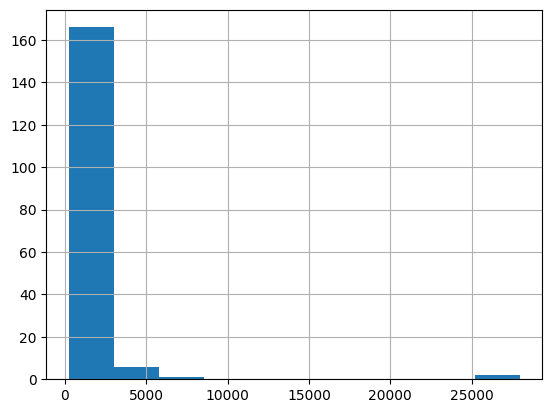

In [31]:
eating_disorders['no_stopwords'].str.len().hist()

In [ ]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
sns.set(rc={'figure.figsize':(11.7,8.27)})

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('spanish'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

In [ ]:
eating_disorders[eating_disorders['label'] == 1]

,text,label
2,Holaa me llamo maria y soy ana ( pronto tambie...,1
4,Este grupo es para presentar dudas de lo que s...,1
5,Buenas noches chicas soy Ana y mia mi peso act...,1
9,Ya salí del otro grupo A bueno señal de aproba...,1
10,Hola tengo 15 años peso 117 mi meta es 90 o me...,1
...,...,...
167,No sufro tampoco mucho con la definición los c...,1
169,"Soy Ari , mia , peso 48 quiero pesar 46 , teng...",1
170,"lol , yo había mandado eso ( a otro grupo ) , ...",1
173,Hola ! Fui mía pero intento ser ana Actualment...,1


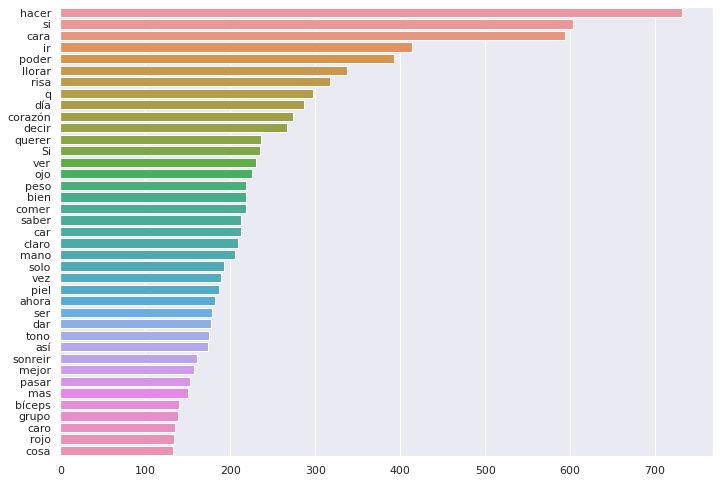

In [ ]:
plot_top_non_stopwords_barchart(eating_disorders['text_lemma'])

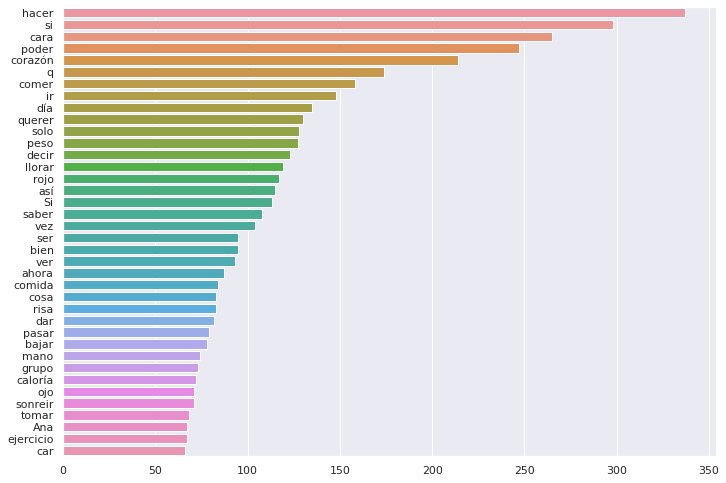

In [ ]:
plot_top_non_stopwords_barchart(eating_disorders[eating_disorders['label'] == 1]['text_lemma'])

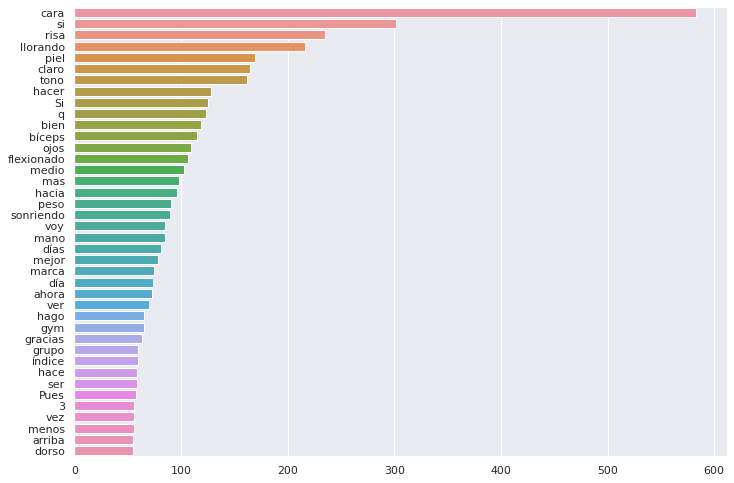

In [ ]:
plot_top_non_stopwords_barchart(eating_disorders[eating_disorders['label'] == 0]['no_stopwords'])

In [ ]:
eating_disorders[eating_disorders['label'] == 1]['text'][12]

'Yo tomo café con leche de soja Me da mucha vergüenza cuando me suena la panza en el trabajo y ni hablar cuando me empiezo a sentir débil o ver " lucecitas de colores " jajaja así que prefiero agregar algo con calorias a mi dia Así que tomo un café con leche en el trabajo de la mañana y otro en el trabajo de la tarde Hola ! Estás en recuperación ? O por qué no se te permite ? cara haciendo una mueca cara pensativa Lavarte cada tanto con agua de perejil hace muy bien ( y aunque no lo creas tiene olor rico jajaja ) . Hace rato que no lo hago pero me había funcionado Pones a hervir un poco de perejil en agua como si fuera un té y listo , colas y te enjuagas el pelo con eso haciendo masajes en el cuero cabelludo No entiendo la diferencia , el te es una infusión cara pensativa Tomar tus propias decisiones e independizarte si es necesario ! Pero si no impones lo que sentis y queres ahora , no lo vas a hacer nunca ... Mis viejos también fueron siempre de la idea " mientras vivas bajo este tec

# TFIDF

In [103]:
#Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Results
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Features
from sklearn.feature_extraction.text import TfidfVectorizer

#CLF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LinearRegression

#time xd
from time import time

## Train y test

In [52]:
eating_disorders['label'].value_counts()

0    101
1     74
Name: label, dtype: int64

In [96]:
# Training dataset
train_data = eating_disorders.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42))

# Testing dataset
test_data = eating_disorders.drop(train_data.index)
print(f'Train: \n' + str(train_data['label'].value_counts()))
print(f'Test: \n'  + str(test_data['label'].value_counts()))

Train: 
0    81
1    59
Name: label, dtype: int64
Test: 
0    20
1    15
Name: label, dtype: int64


## Pipeline

In [129]:
column_to_vectorize = 'text_lemma_no_stopwords' #'text', 'no_stopwords', 'text_lemma', 'text_lemma_no_stopwords'

#TFIDF features
tfidf = TfidfVectorizer(stop_words= list(stop_words) + ['q'], 
                        ngram_range = (1,2)
                        )
      # decode_error = 'ignore')

clmn = ColumnTransformer([("tfidf", tfidf, column_to_vectorize)],
                         remainder="drop")

prepro_pipe = Pipeline(
    [
        ("preprocesamiento", clmn),
    ]
)

linear_svc_pipe = Pipeline(
    [
        ("preprocesamiento", clmn),
        ("linear_SVM", SVC(kernel="linear")),
    ]
)

svc_pipe = Pipeline(
    [("preprocesamiento", clmn), 
     ("SVM", SVC(kernel="rbf"))]
)

mnb_pipe = Pipeline(
    [("preprocesamiento", clmn), 
     ("MultiNB", MultinomialNB(alpha=0.01))]
)

knn_pipe = Pipeline(
    [("preprocesamiento", clmn), 
     ("KNN", KNeighborsClassifier())]
)

In [130]:
column_to_vectorize = 'text_lemma_no_stopwords' #'text', 'no_stopwords', 'text_lemma', 'text_lemma_no_stopwords'

df_y = eating_disorders["label"]
df_X = eating_disorders#.drop(["Name", "National_Position", "target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, random_state=42, stratify=df_y
)

linear_svc = linear_svc_pipe.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
print('Resultados Linear SVC:')
print(classification_report(y_pred, y_test))

rbf_svc = svc_pipe.fit(X_train, y_train)
y_pred = rbf_svc.predict(X_test)
print('Resultados RBF SVC')
print(classification_report(y_pred, y_test))

mnb_clf = mnb_pipe.fit(X_train, y_train)
y_pred = mnb_clf.predict(X_test)
print('Resultados MultinomialNB:')
print(classification_report(y_pred, y_test))

knn = knn_pipe.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Resultados KNN')
print(classification_report(y_pred, y_test))

Resultados Linear SVC:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.87      1.00      0.93        13

    accuracy                           0.94        35
   macro avg       0.93      0.95      0.94        35
weighted avg       0.95      0.94      0.94        35

Resultados RBF SVC
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        27
           1       0.53      1.00      0.70         8

    accuracy                           0.80        35
   macro avg       0.77      0.87      0.77        35
weighted avg       0.89      0.80      0.82        35

Resultados MultinomialNB:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.87      1.00      0.93        13

    accuracy                           0.94        35
   macro avg       0.93      0.95      0.94        35
weight